In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgmp
import seaborn as sns
import timeit
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from tqdm import tqdm
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [7]:
from google.colab import drive
drive.mount('/content/ShardDrives/', force_remount=True)

Mounted at /content/ShardDrives/


In [3]:
# import utils own functions
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [42]:
cd ..

/content


In [43]:
!pwd

/content


In [44]:
!rm -rf blood_dataset/

In [5]:
# !mkdir blood_dataset

In [ ]:
!unzip /content/ShardDrives/MyDrive/bloods/blood_dataset.zip 

In [46]:
cd blood_dataset

/content/blood_dataset


In [47]:
!pwd

/content/blood_dataset


In [ ]:
#  !rm -rf /content/Road_Sign_Dataset//

In [48]:
class_list = ["basophil" ,"eosinophil","erythroblast","lymphocyte","monocyte","neutrophil"]

In [50]:
!mkdir images

In [51]:
for class_name in class_list:
  print(class_name)
  !mv {class_name} '/content/blood_dataset/images/'{class_name}

basophil
eosinophil
erythroblast
lymphocyte
monocyte
neutrophil


In [52]:
os.path.join( "images")

'images'

In [55]:
images_directory = '/content/blood_dataset/images'

In [56]:
glob_list = os.listdir(images_directory)

In [58]:
print("Nombre de globule blancs dans le dataset:", (len(glob_list)))
nb_photos_pear_races = [len(os.listdir(images_directory + "/" + name))for name in glob_list]

Nombre de globule blancs dans le dataset: 6


In [59]:
df_glob = pd.DataFrame(
    index=glob_list,
    data=nb_photos_pear_races,
    columns=["nb_photos"])

df_glob

,nb_photos
erythroblast,1551
basophil,1218
lymphocyte,1214
neutrophil,3330
eosinophil,3117
monocyte,1420


In [60]:
df_glob.nb_photos.sum()

11850

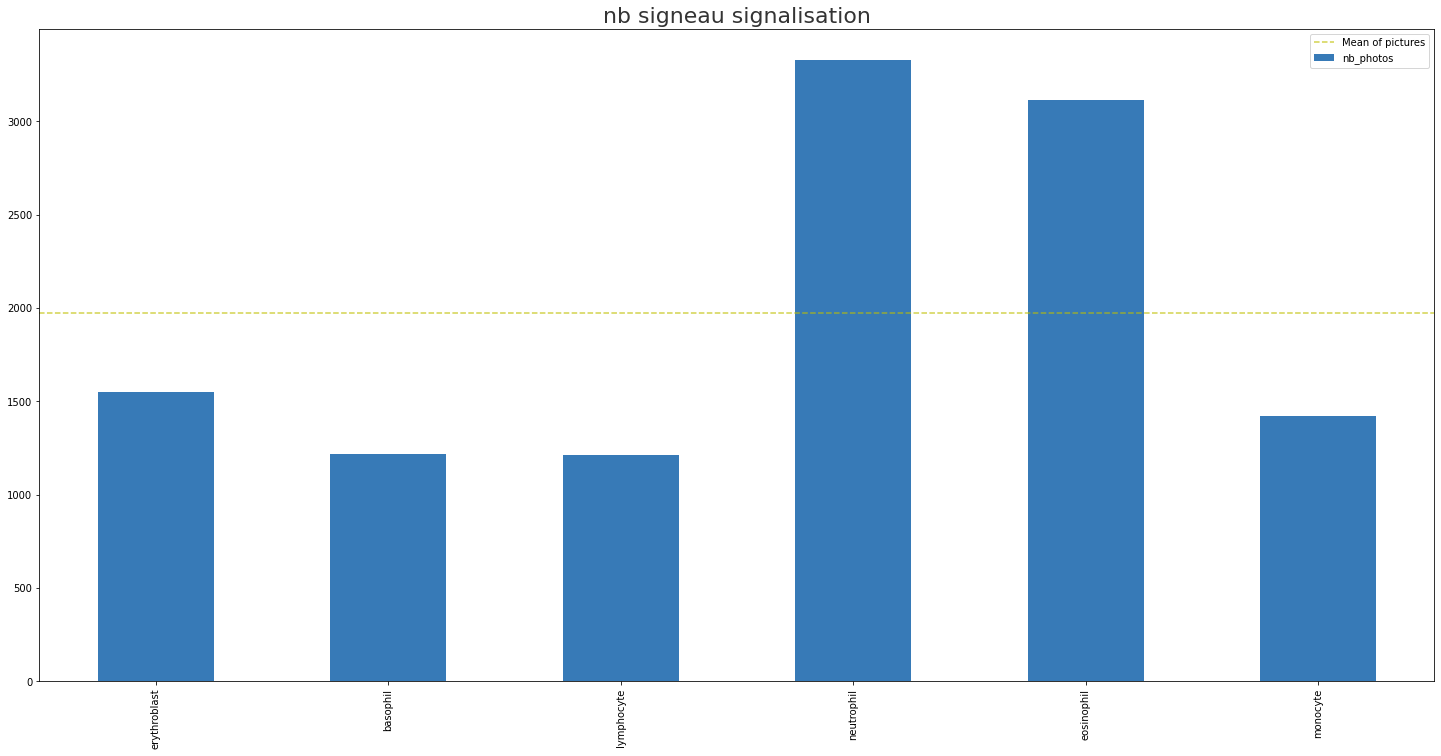

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_glob.plot(kind="bar",color='#377AB7',
               legend=False,
               ax=ax)
ax.axhline(df_glob["nb_photos"].mean(),
           color='y', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("nb signeau signalisation",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

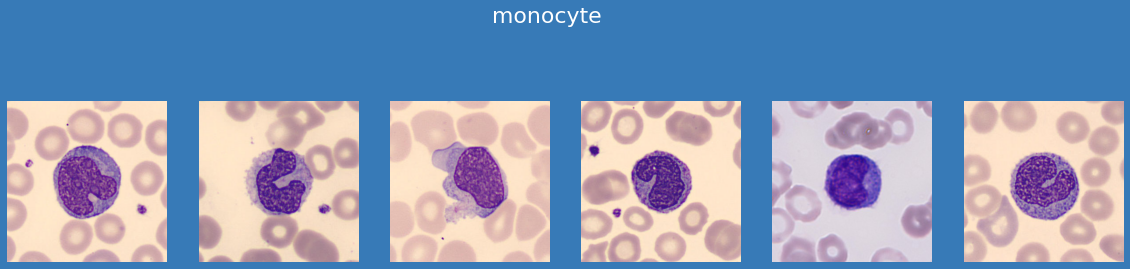

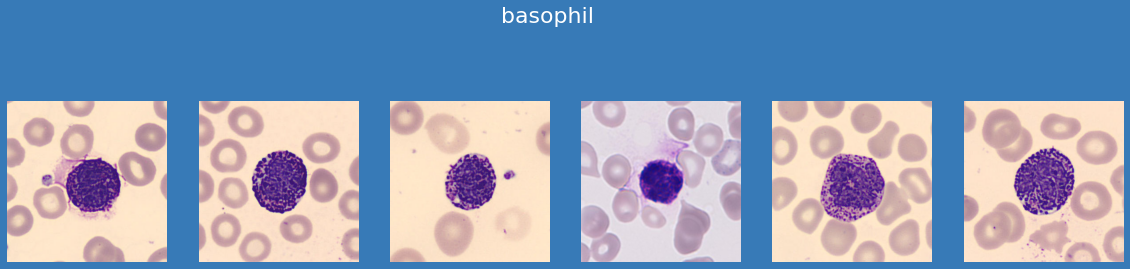

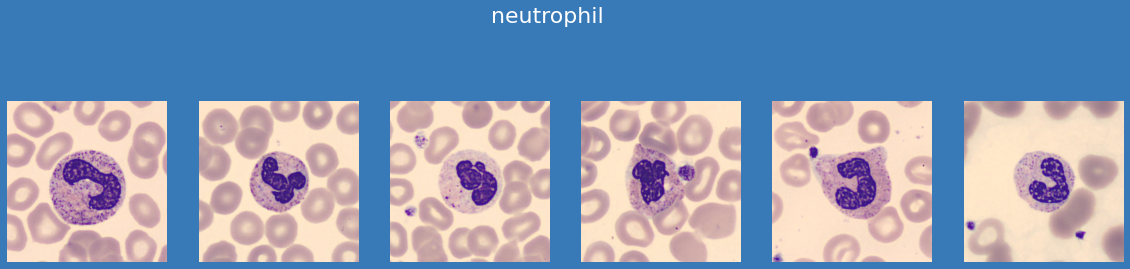

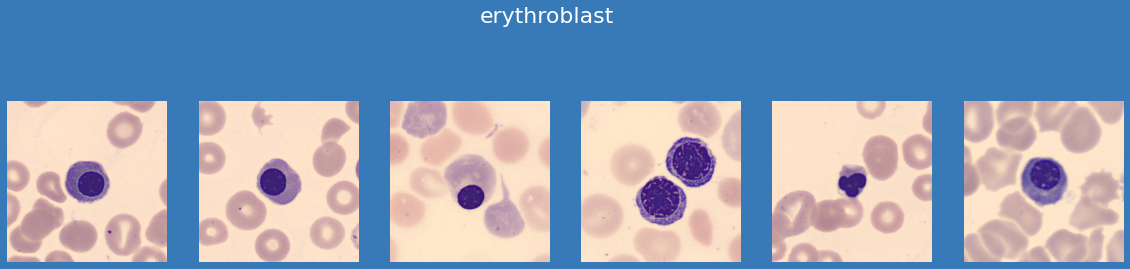

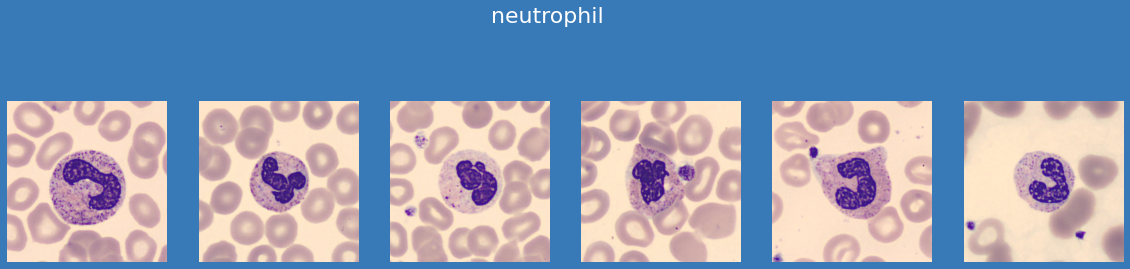

In [62]:
for i in np.random.randint(0, len(glob_list), size=5):
    utils.show_images_from_directory(images_directory, glob_list[i], 6)

In [87]:
def preprocessing(directories,images_directory, img_width, img_height):
#     fonction de preprocessing de nos images
#     applique les differents filtres vu ci dessus
    img_list=[]
    labels=[]
    for index, race in enumerate(directories):
        for image_name in tqdm(os.listdir(images_directory+"/"+race)):
          # print(images_directory+"/"+race+'/'+image_name)
        # if(os.path.isfile(images_directory+"/"+race+'/'+image_name)):
            # Read image
            img = cv.imread(images_directory+"/"+race+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Equalization
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convert modified img to array
            img_array = image.img_to_array(dst_img)            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(race)
    
    return img_list, labels

In [ ]:
!rm /content/blood_dataset/images/neutrophil/.DS_169665.jpg

In [89]:
X, y = preprocessing(class_list, images_directory,  299, 299)

100%|██████████| 3329/3329 [22:00<00:00,  2.52it/s]


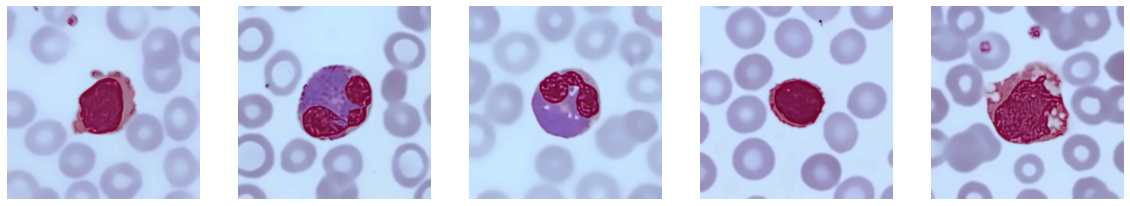

In [93]:
utils.show_images_sample(X,num_sample=5)

In [94]:
!pip install hickle

     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 2.9 MB 29.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [96]:
# Convert in numpy array
X = np.array(X)
y = np.array(y)

In [98]:
print("Number of images preprocessed : {}".format(len(y)))
print("Shape of images np.array : {}".format(X.shape))

Number of images preprocessed : 11849
Shape of images np.array : (11849, 299, 299, 3)


In [99]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(10)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

In [129]:
import hickle as hkl
data = {'X': X, 'y': y}
hkl.dump(data,'/content/ShardDrives/MyDrive/bloods/data.hkl')

In [100]:
# Encode y text data to numeric
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

In [110]:
print(encoder.classes_)
print(len(encoder.classes_))

['basophil' 'eosinophil' 'erythroblast' 'lymphocyte' 'monocyte'
 'neutrophil']
6


In [102]:
X = X.astype(np.float32)

In [103]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 8)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

Train set size =  9479
Test set size =  2370


In [104]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

In [105]:
print(tf.__version__)

2.8.0


In [106]:
# Metrics have been removed from Keras core. We need to calculate them manually
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [107]:
def plot_history_scores(dict_history,modele_name, first_score, second_score):
  fig = plt.figure(figsize=(25,10))
  # summarize history for accuracy
  plt.subplot(1, 2, 1)
  plt.plot(dict_history[first_score])
  plt.plot(dict_history['val_' + first_score],
            linestyle='--', color="red")
  plt.title(modele_name+' '+ first_score, fontsize=18)
  plt.ylabel(first_score)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  # summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(dict_history[second_score])
  plt.plot(dict_history['val_' + second_score],
            linestyle='--', color="red")
  plt.title(modele_name +' '+ second_score, fontsize=18)
  plt.ylabel(second_score)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [108]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))
xception_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [109]:
for layer in xception_model.layers:
    layer.trainable = False

In [111]:
# Add new fully-connected layers
# print(encoder.classes_)
output = xception_model.output
output = Dense(128, activation='relu')(output)
output = Dropout(0.2)(output)
# Output : new classifier
predictions = Dense(len(encoder.classes_), activation='softmax')(output)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])
my_xcept_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [112]:
# Data generator on train set with Data Augmentation
# and preprocess_input Xception
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [113]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    verbose=2)

Epoch 1/50
296/296 - 131s - loss: 0.7727 - accuracy: 0.7365 - f1_m: 1.9236 - val_loss: 0.4549 - val_accuracy: 0.8501 - val_f1_m: 1.4388 - 131s/epoch - 443ms/step
Epoch 2/50
296/296 - 116s - loss: 0.4142 - accuracy: 0.8624 - f1_m: 1.3148 - val_loss: 0.3325 - val_accuracy: 0.8918 - val_f1_m: 1.2245 - 116s/epoch - 390ms/step
Epoch 3/50
296/296 - 116s - loss: 0.3488 - accuracy: 0.8834 - f1_m: 1.2271 - val_loss: 0.2962 - val_accuracy: 0.9055 - val_f1_m: 1.2265 - 116s/epoch - 391ms/step
Epoch 4/50
296/296 - 117s - loss: 0.3103 - accuracy: 0.8973 - f1_m: 1.1748 - val_loss: 0.2864 - val_accuracy: 0.9087 - val_f1_m: 1.2042 - 117s/epoch - 395ms/step
Epoch 5/50
296/296 - 116s - loss: 0.2821 - accuracy: 0.9009 - f1_m: 1.1659 - val_loss: 0.2539 - val_accuracy: 0.9193 - val_f1_m: 1.1465 - 116s/epoch - 392ms/step
Epoch 6/50
296/296 - 116s - loss: 0.2815 - accuracy: 0.9040 - f1_m: 1.1443 - val_loss: 0.2366 - val_accuracy: 0.9208 - val_f1_m: 1.1488 - 116s/epoch - 393ms/step
Epoch 7/50
296/296 - 116s - 

In [ ]:
!pip install keras-tuner

In [114]:
my_xcept_model.save('/content/ShardDrives/MyDrive/bloods/my_xcept_model_blood.h5')

In [115]:
import json
history_xcept_dict = history_xcept.history
# Save it under the form of a json file
json.dump(history_xcept_dict, open('/content/ShardDrives/MyDrive/bloods/history_xcept_blood', 'w'))
history_xcept_dict = json.load(open('/content/ShardDrives/MyDrive/bloods/history_xcept_blood', 'r'))

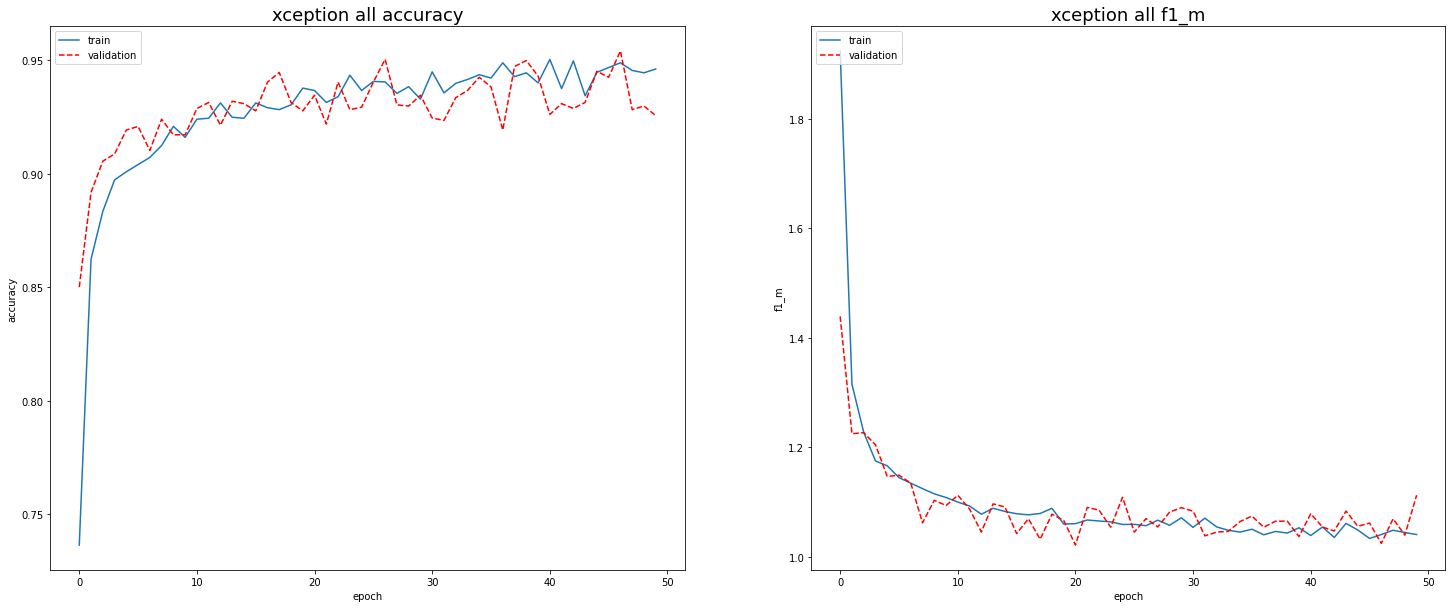

In [116]:
plot_history_scores(
    dict_history = history_xcept_dict, 
    modele_name='xception all',
    first_score = "accuracy", 
    second_score = "f1_m")

In [117]:
# Make predictions
Y_pred = history_xcept.model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

In [119]:
encoder.classes_

array(['basophil', 'eosinophil', 'erythroblast', 'lymphocyte', 'monocyte',
       'neutrophil'], dtype='<U12')

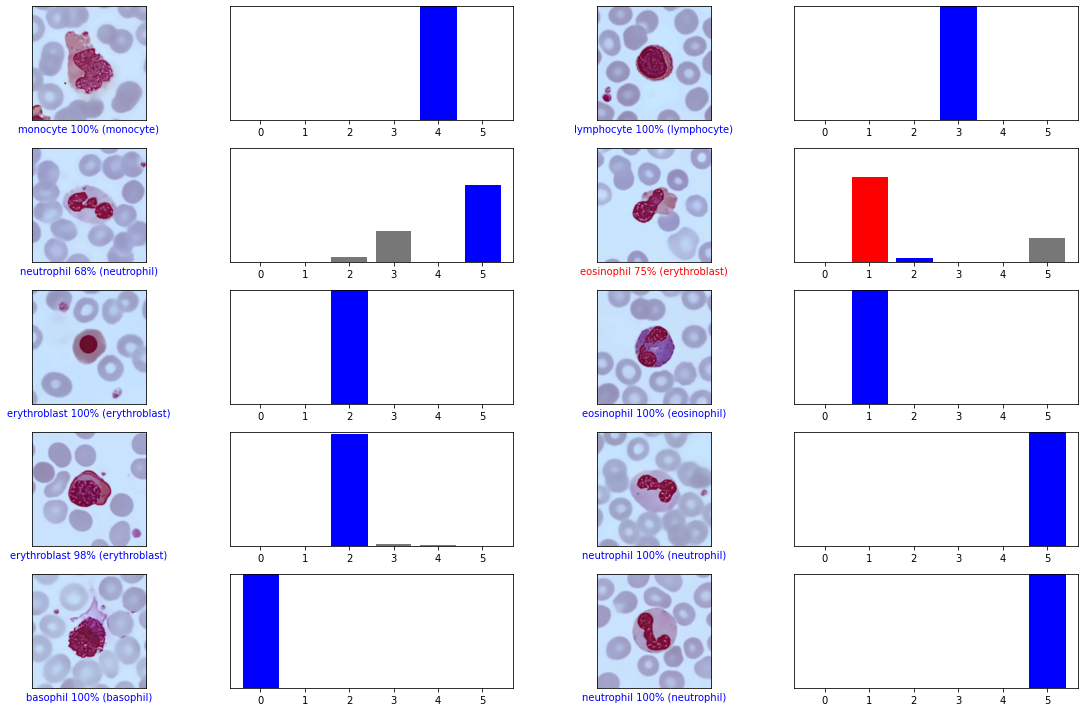

In [127]:
class_names = encoder.classes_
num_class = len(class_names) 
utils.plot_predictions(x_test,y_test,Y_pred, class_names,num_class)

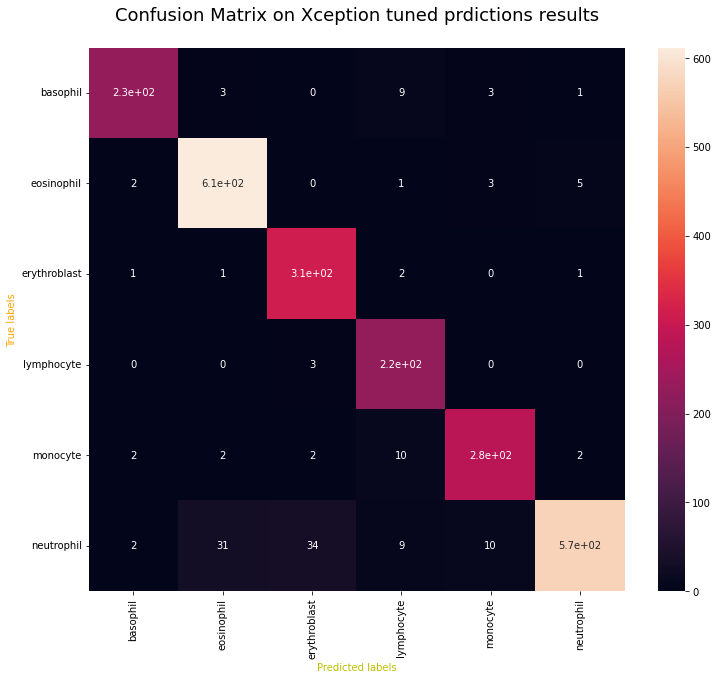

In [122]:
fig = plt.figure(figsize=(12,10))
# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_xlabel("Predicted labels", color="y")
ax.set_ylabel("True labels", color="orange")
ax.xaxis.set_ticklabels(encoder.classes_, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Confusion Matrix on Xception tuned prdictions results\n",
          fontsize=18)
plt.show()

In [123]:
print(classification_report(
    y_test, y_pred, 
    target_names=sorted(set(encoder.classes_))))

              precision    recall  f1-score   support

    basophil       0.97      0.93      0.95       245
  eosinophil       0.94      0.98      0.96       623
erythroblast       0.89      0.98      0.93       316
  lymphocyte       0.88      0.99      0.93       228
    monocyte       0.95      0.94      0.94       299
  neutrophil       0.98      0.87      0.92       659

    accuracy                           0.94      2370
   macro avg       0.94      0.95      0.94      2370
weighted avg       0.94      0.94      0.94      2370



In [ ]:
# !rm -rf -d labels/*.xml